In [47]:
library('edgeR')
library('knitr')
library('IRdisplay')
library('repr')
library('qvalue')
library('DESeq')
library('baySeq')

In [48]:
input_filename = "../data/test_scounts.csv"
results_folder = "../results"

c1 <- 2
g1 <- 3
c2 <- 5
g2 <- 3

#Apply default settings
min_row_count <- 3
pvalue <- 0.05
dispersion <- 0.4
tagwise_flag <- T
qvalue_flag <- T
sampsize <- 1000

In [49]:
# Read and Filter Data
now <- format(Sys.time(), "%m-%d-%Y_%H-%M-%S")
analysis.time <- paste("MultiSpec Analysis Started on", format(Sys.time(), "%m-%d-%Y"), "at", format(Sys.time(), "%H:%M:%S"), sep=" ")
cat("\n\n")
cat(analysis.time, "\n")
cat("\nRunning MultiSpec - A multi-DE Analysis\n")
cat(paste("Significant Threshold =", pvalue, "\n"))

#Read Data from formatted CSV file
cat("\n")
cat(paste("Performing MultiSpec Analysis on:\n", "Data File:", input_filename,"\n"))
datafile <- read.csv(file=input_filename, head = TRUE)

cat(paste("  Group 1 spectral counts in columns",c1,"-",c1+g1-1,
            "\n  Group 2 spectral counts in columns", c2,"-",c2+g2-1, "\n"))
datafile.counts <- cbind(datafile[, c1:(c1+g1-1)],datafile[, c2:(c2+g2-1)])
rownames(datafile.counts) = datafile[, 1]

#filter data such that a row must have = specified min counts
cat(paste("\nFiltering Protein IDs with fewer than",min_row_count,"Total Spectral Counts\n"))
cat(paste("  Proteins before filtering = ",nrow(datafile.counts),"\n"))
filt.counts <- datafile.counts[rowSums(datafile.counts) >= min_row_count, ]
cat(paste("  Proteins after filetering = ", nrow(filt.counts),"\n"))



MultiSpec Analysis Started on 10-02-2018 at 15:17:01 

Running MultiSpec - A multi-DE Analysis
Significant Threshold = 0.05 

Performing MultiSpec Analysis on:
 Data File: ../data/test_scounts.csv 
  Group 1 spectral counts in columns 2 - 4 
  Group 2 spectral counts in columns 5 - 7 

Filtering Protein IDs with fewer than 3 Total Spectral Counts
  Proteins before filtering =  479 
  Proteins after filetering =  476 


In [50]:
############################################
# Run edgeR Analysis
cat("\n")
cat("Starting edgeR Analysis\n")

#format taks for SMEAR MVA plot
options(digits = 4)

#create DGEList 
datafile.dgelist <- DGEList(counts=filt.counts, group=c(rep(0,g1),rep(1,g2)))

#Normalize data
cat("TMM Normalizing Data\n")
datafile.dgelist <- calcNormFactors(datafile.dgelist)

#Estimate Common Dispersion
if ((g1 == 1) & (g2 == 1)) {
	datafile.dgelist$common.dispersion = dispersion
	cat(paste("NO REPLICATION - > common dispersion estimated =", datafile.dgelist$common.dispersion,"\n"))

} else {
	datafile.dgelist <- estimateCommonDisp(datafile.dgelist)
	cat(paste("Common Dispersion =", datafile.dgelist$common.dispersion,"\n"))
    plot_MDS_MV = T
	if (tagwise_flag == T) {
    	plot_BCV = T
        cat(paste("Tagwise Dispersion Enabled\n"))
	    datafile.dgelist <- estimateTagwiseDisp(datafile.dgelist,trend="none")
    }
}

#perform exact test to determine proteins differentially experessed
cat(paste("Performing edgeR Exact Test" ,"\n"))
datafile.dgelist.results <- exactTest(datafile.dgelist)

#perform multiple comparison correction
cat(paste("Performing BH Multitest Correction for Significance at p-Value =", pvalue ,"\n"))
BH.mt.adj <- decideTestsDGE(datafile.dgelist.results , adjust.method="BH", p.value=pvalue)

top <- topTags(datafile.dgelist.results , n = sum(datafile.dgelist.results $table$PValue < pvalue))
detags <- rownames(top$table)
final_results <- cbind(datafile.dgelist$counts,datafile.dgelist.results$table,BH.mt.adj)


Starting edgeR Analysis
TMM Normalizing Data
Common Dispersion = 0.209039598342658 
Tagwise Dispersion Enabled
Performing edgeR Exact Test 
Performing BH Multitest Correction for Significance at p-Value = 0.05 


In [51]:
#create BCV plot
pdf("../results/edger_bcv.pdf")
if (plot_BCV) {
    cat(paste("Creating edgeR BCV Plot" ,"\n"))#BCVPDFfile <- paste(filename,now,"edgeR_BCV.pdf")
    plotBCV(datafile.dgelist, col.common="dodger blue", cex=0.4, main="BCV Estimates", 
            xlab=expression(Average~Log[2]~CPM), 
            ylab=expression(paste("Biological Coefficient of Variation Estimate,  ", 
                                  sqrt(phi)
                                 )
                           )
           )
}
dev.off()

Creating edgeR BCV Plot 


png 
  2

In [52]:
#create MDS plot
pdf("../results/edger_mds.pdf")
if (plot_MDS_MV) {

    cat(paste("Creating edgeR MDS Plot" ,"\n"))
    #MDSPDFfile <- paste(filename,now,"edgeR_MDS.pdf")
    #pdf(file=MDSPDFfile)
    MDStitle <- list(bquote("limma Multidimensional Scaling Plot"), bquote("Common Euclidean Distance of Top 100 of Proteins"))
    plotMDS(datafile.dgelist, top=100, gene.selection="common", col=c(rep("black", g1), rep("red", g1)), xlab=expression(Log[2]~Fold~Change~Dimension~1), ylab=expression(Log[2]~Fold~Change~Dimension~2), main=mtext(do.call(expression, MDStitle), side=3, line=1:0, cex=c(1.25,0.75), col=c("black", "red")), ylim=c(-2, 2), xlim=c(-2, 2))
    #garbage <- dev.off()    
}
dev.off()

Creating edgeR MDS Plot 


png 
  2

In [53]:
#create Mean Variance plot
pdf("../results/edger_mv.pdf")
if (plot_MDS_MV) {
    cat(paste("Creating edgeR MV Plot" ,"\n"))
    par(cex.axis=0.75, cex.lab=1)
    plotMeanVar(datafile.dgelist, show.raw.vars=T, show.binned.common.disp.vars=F, show.ave.raw.vars=T, nbin=50, bty="n", log.axes=("xy"), las=1, main="edgeR Mean-Variance Relationship Plot", grid(nx=NA, ny=NA))
}
dev.off()

Creating edgeR MV Plot 


png 
  2

In [54]:
#create SMEAR plot
pdf("../results/edger_smear.pdf")
cat(paste("Creating edgeR SMEAR Plot" ,"\n"))
plotSmear(datafile.dgelist.results , de.tags = detags, las=1, 
          col="gray", cex=0.8, pch=21, bg="black", 
          main = expression(edgeR~Fold~Change~Smear~Plot), 
          xlab=expression(Average~Log[2]~CPM), 
          ylab=expression(Log[2]~Fold~Change), 
          panel.first=c(abline(h = c(-1, 1), lty=2, 
          lwd=2, col = "dodgerblue"), grid()))
dev.off()

Creating edgeR SMEAR Plot 


png 
  2

In [55]:

if (qvalue_flag == TRUE){
    cat(paste("Calculating edgeR q-Values\n"))
    qobj <- qvalue(final_results$PValue, fdr.level=pvalue, pi0.method="bootstrap")  
    tmp_edger <- cbind(final_results,qobj$qvalues,qobj$significant)
    names(tmp_edger)[names(tmp_edger)=="qobj$qvalues"] <- "e_qvalue"
    names(tmp_edger)[names(tmp_edger)=="qobj$significant"] <- "e_significant"
}


Calculating edgeR q-Values


In [56]:
pdf("../results/edger_qvalue.pdf")
if (qvalue_flag == TRUE){
    cat(paste("Plotting edgeR q-Values\n"))
    plot(qobj)
}
dev.off()

Plotting edgeR q-Values


png 
  2

In [57]:
#output final results
cat(paste("Writing edgeR Results Table" ,"\n"))

outfile <- file.path(paste(input_filename,now,"edgeR.csv"))
edger.out.data <- cbind(substring(row.names(tmp_edger), 4, 9), tmp_edger)
colnames(edger.out.data)[1] <- c("UniProtID")
write.table(edger.out.data[order(edger.out.data$PValue), ] , file=outfile, sep=",", col.names=NA)


Writing edgeR Results Table 


In [45]:
#options(repr.vector.quote=FALSE)
edger.out.data[order(edger.out.data$PValue), ]

,UniProtID,X03292017_UnX_IP2_,X03292017_UnX_IP3_,X03292017_UnX_IP4_,X03292017_WT_IP2_,X03292017_WT_IP3_,X03292017_WT_IP4_,logFC,logCPM,PValue,0+1,e_qvalue,e_significant
sp|Q04695|K1C17_HUMAN Keratin; type I cytoskeletal 17 OS=Homo sapiens GN=KRT17 PE=1 SV=2,Q04695,53,73,85,10,8,8,-3.022,12.356,4.050e-08,-1,1.928e-05,TRUE
sp|P09493|TPM1_HUMAN Tropomyosin alpha-1 chain OS=Homo sapiens GN=TPM1 PE=1 SV=2,P09493,39,22,8,0,1,0,-5.752,10.730,2.607e-07,-1,6.205e-05,TRUE
sp|O75530|EED_HUMAN Polycomb protein EED OS=Homo sapiens GN=EED PE=1 SV=2,O75530,0,0,0,7,6,12,6.174,9.607,1.936e-05,1,2.545e-03,TRUE
sp|P07951|TPM2_HUMAN Tropomyosin beta chain OS=Homo sapiens GN=TPM2 PE=1 SV=1,P07951,17,11,5,0,1,0,-4.682,9.884,2.139e-05,-1,2.545e-03,TRUE
sp|Q15022|SUZ12_HUMAN Polycomb protein SUZ12 OS=Homo sapiens GN=SUZ12 PE=1 SV=3,Q15022,0,0,2,21,7,15,4.269,10.267,3.366e-05,1,3.205e-03,TRUE
sp|P15924|DESP_HUMAN Desmoplakin OS=Homo sapiens GN=DSP PE=1 SV=3,P15924,35,22,23,4,6,6,-2.352,11.153,1.251e-04,-1,9.926e-03,TRUE
sp|Q15910|EZH2_HUMAN Histone-lysine N-methyltransferase EZH2 OS=Homo sapiens GN=EZH2 PE=1 SV=2,Q15910,0,0,0,4,4,12,5.889,9.405,1.980e-04,1,1.347e-02,TRUE
sp|P05783|K1C18_HUMAN Keratin; type I cytoskeletal 18 OS=Homo sapiens GN=KRT18 PE=1 SV=2,P05783,56,68,70,22,28,18,-1.558,12.477,2.827e-04,-1,1.682e-02,TRUE
sp|P21333|FLNA_HUMAN Filamin-A OS=Homo sapiens GN=FLNA PE=1 SV=4,P21333,129,121,140,35,39,49,-1.657,13.448,7.025e-04,-1,3.138e-02,TRUE
sp|P62258|1433E_HUMAN 14-3-3 protein epsilon OS=Homo sapiens GN=YWHAE PE=1 SV=1,P62258,0,0,0,8,4,3,5.395,9.118,7.251e-04,1,3.138e-02,TRUE


In [46]:
############################################
# Run DESeq Analysis
cat("\n")
cat("Performing DESeq Analysis\n")
conditions = factor( c(rep(0,g1),rep(1,g2)))
cds <- newCountDataSet(filt.counts, conditions)
cat("RLE Normalizing Data\n")
cds <- estimateSizeFactors(cds)

if ((g1 != 1) & (g2 != 1)) {
    cds <- estimateDispersions(cds, method="pooled", sharingMode="maximum", fitType="local")
    cat("Pooled Dispersion Estimated\n")
    cat("Local-Linear Dispersion-Mean Relationship Chosen\n")
    cat("Maximum Dispersion Estimate Selected\n")
} else {
    cds <- estimateDispersions(cds, method="blind", sharingMode="fit-only")
	cat("NO REPLICATION -> Blind Dispersion Estimated\n")
    cat("Local-Linear Dispersion-Mean Relationship Chosen\n")
    cat("Maximum Dispersion Estimate Selected\n")
}

res = nbinomTest( cds, "0", "1" )


Performing DESeq Analysis
RLE Normalizing Data
Pooled Dispersion Estimated
Local-Linear Dispersion-Mean Relationship Chosen
Maximum Dispersion Estimate Selected


Creating DESeq Dispersion-Mean Plot 


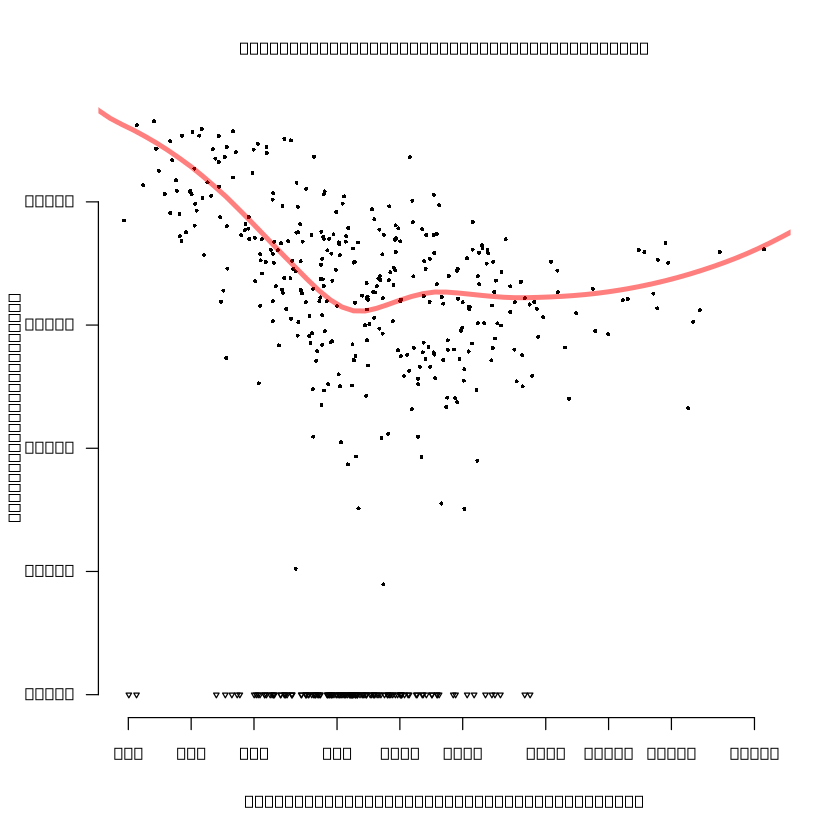

In [21]:
#Create MV plot
if ((g1 != 1) & (g2 != 1)) {
    cat(paste("Creating DESeq Dispersion-Mean Plot" ,"\n"))
    #DESEQDISPPDFfile <- paste(filename,now,"DESeq_Dispersion-Mean.pdf")
    #pdf(file=DESEQDISPPDFfile )
    par(cex.axis=0.75, cex.lab=1)
    plotDispEsts(cds, bty="n", las=1, main="DESeq Fitted Mean-Dispersion Relationship", xlab="Mean of Upper Quartile Normalized Counts", ylab=expression(paste("Dispersion Estimate,  ", phi)))
    #garbage <- dev.off()
}

Creating DESeq MA Plot


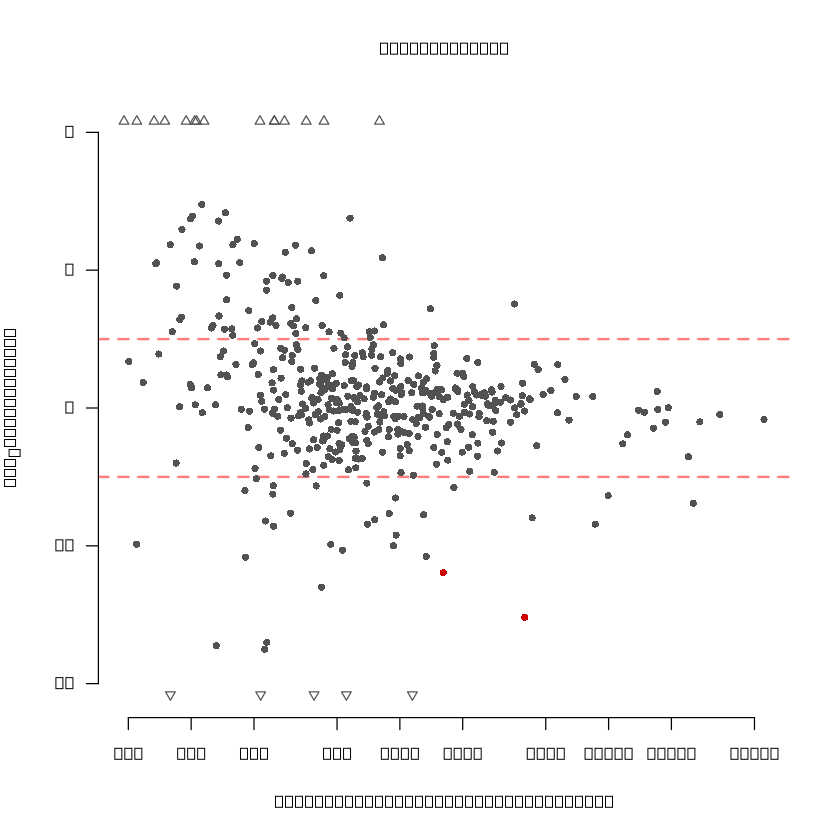

In [22]:
if ((g1 != 1) & (g2 != 1)) {
    cat(paste("Creating DESeq MA Plot\n"))
    #DESEQMAPDFfile <- paste(filename,now,"DESeq_MA.pdf")
    #pdf(file=DESEQMAPDFfile )
    plotMA(res, las=1, bty="n", cex=0.8, linecol = NA, panel.first=c(abline(h = c(-1, 1), lty=2, lwd=2, col="#ff000080")), xlab="Mean of Quantile Normalized Counts", ylab=expression(Log[2]~Fold~Change), main="DESeq MA Plot", cex.lab=1.2)
    #garbage <- dev.off()
}

Calculating DESeq q-Values 


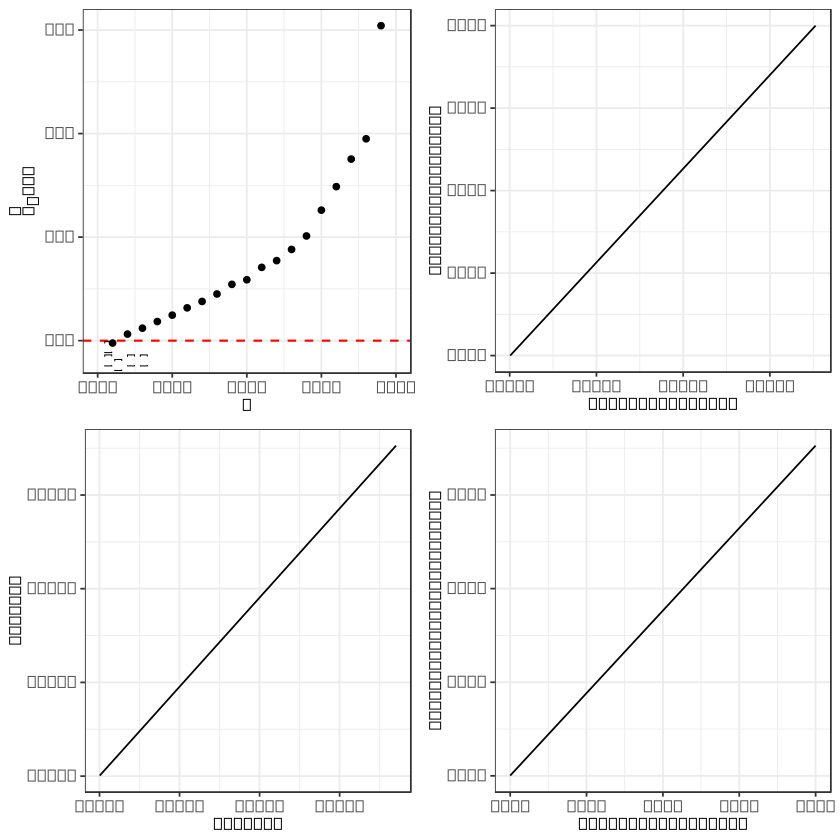

In [23]:
if (qvalue_flag == TRUE){
    qobj <- qvalue(res$pval, fdr.level=pvalue, pi0.method="bootstrap")
    #QPDFfile <- paste(filename,now,"DESeq_qValue.pdf")
    #pdf(file=QPDFfile)
    plot(qobj)
    #garbage <- dev.off()
    cat(paste("Calculating DESeq q-Values" ,"\n"))
    tmp_deseq <- cbind(res,qobj$qvalues,qobj$significant)
    names(tmp_deseq)[names(tmp_deseq)=="qobj$qvalues"] <- "d_qvalue"
    names(tmp_deseq)[names(tmp_deseq)=="qobj$significant"] <- "d_significant"
}

In [24]:
cat("Writing DESeq Results Table\n")
outfile <- file.path(paste(input_filename,now,"DESeq.csv"))
deseq.out.data <- (cbind(tmp_deseq[,1], substring(tmp_deseq[,1], 4, 9), tmp_deseq[,2:ncol(tmp_deseq)]))
colnames(deseq.out.data)[1:2] <- c("","UniProtID")
write.table(deseq.out.data[order(deseq.out.data$pval), ] , file=outfile, sep=",", row.names=F)

Writing DESeq Results Table


In [25]:
#options(repr.vector.quote=FALSE)
deseq.out.data[order(deseq.out.data$pval), ]

,,UniProtID,baseMean,baseMeanA,baseMeanB,foldChange,log2FoldChange,pval,padj,d_qvalue,d_significant
13,sp|Q04695|K1C17_HUMAN Keratin; type I cytoskeletal 17 OS=Homo sapiens GN=KRT17 PE=1 SV=2,Q04695,39.647,70.6850,8.6090,0.121793,-3.037,3.032e-07,0.0001443,0.0001443,TRUE
146,sp|P15924|DESP_HUMAN Desmoplakin OS=Homo sapiens GN=DSP PE=1 SV=3,P15924,16.145,27.1146,5.1759,0.190889,-2.389,3.705e-04,0.0881749,0.0881749,FALSE
197,sp|O75530|EED_HUMAN Polycomb protein EED OS=Homo sapiens GN=EED PE=1 SV=2,O75530,4.329,0.0000,8.6571,Inf,Inf,6.569e-04,0.1015564,0.1015564,FALSE
166,sp|P07951|TPM2_HUMAN Tropomyosin beta chain OS=Homo sapiens GN=TPM2 PE=1 SV=1,P07951,5.542,10.8626,0.2214,0.020386,-5.616,9.146e-04,0.1015564,0.1015564,FALSE
114,sp|O14654|IRS4_HUMAN Insulin receptor substrate 4 OS=Homo sapiens GN=IRS4 PE=1 SV=1,O14654,5.770,1.4892,10.0509,6.749045,2.755,1.067e-03,0.1015564,0.1015564,FALSE
43,sp|P09493|TPM1_HUMAN Tropomyosin alpha-1 chain OS=Homo sapiens GN=TPM1 PE=1 SV=2,P09493,11.483,22.7448,0.2214,0.009736,-6.682,1.569e-03,0.1167547,0.1167547,FALSE
21,sp|P21333|FLNA_HUMAN Filamin-A OS=Homo sapiens GN=FLNA PE=1 SV=4,P21333,86.244,131.5783,40.9092,0.310911,-1.685,1.796e-03,0.1167547,0.1167547,FALSE
115,sp|Q15022|SUZ12_HUMAN Polycomb protein SUZ12 OS=Homo sapiens GN=SUZ12 PE=1 SV=3,Q15022,7.984,0.7739,15.1937,19.631349,4.295,1.962e-03,0.1167547,0.1167547,FALSE
20,sp|P05783|K1C18_HUMAN Keratin; type I cytoskeletal 18 OS=Homo sapiens GN=KRT18 PE=1 SV=2,P05783,43.036,64.6700,21.4017,0.330936,-1.595,4.127e-03,0.1837860,0.1837860,FALSE
145,sp|Q05682|CALD1_HUMAN Caldesmon OS=Homo sapiens GN=CALD1 PE=1 SV=3,Q05682,9.317,14.9001,3.7340,0.250602,-1.997,4.336e-03,0.1837860,0.1837860,FALSE


In [26]:
############################################
# Run baySeq Analysis
cat("Performing baySeq Analysis\n")

replicates <- c(rep(1,g1),rep(2,g2))
groups <- list(NDE = c(rep(1,g1),rep(1,g2)), DE = c(rep(1,g1),rep(2,g2)) )
counts <- as.matrix(filt.counts)

cat("TMM Normalizing Data\n")
CD <- new("countData", data = counts, replicates = replicates, groups = groups)
CD@annotation <- as.data.frame(row.names(filt.counts))
libsizes(CD) <- getLibsizes(CD, estimationType="edgeR")
cl <- NULL
CDP.NBML <- getPriors.NB(CD, samplesize = sampsize, estimation = "QL", cl = cl)
CDPost.NBML <- getLikelihoods(CDP.NBML, pET = 'BIC', cl = cl)
bayseq <- topCounts(CDPost.NBML, number = nrow(CDPost.NBML@annotation), group = "DE")
bayseq.DE <- topCounts(CDPost.NBML, group = "DE", FDR=pvalue)

Performing baySeq Analysis
TMM Normalizing Data


Finding priors...done.
Finding posterior likelihoods...Length of priorReps:0
Length of priorSubset:476
Length of subset:476
Length of postRows:476
Analysing part 1 of 1
Preparing data.......................................................done.
Estimating likelihoods......done!


.

done.


Creating baySeq MA plot 


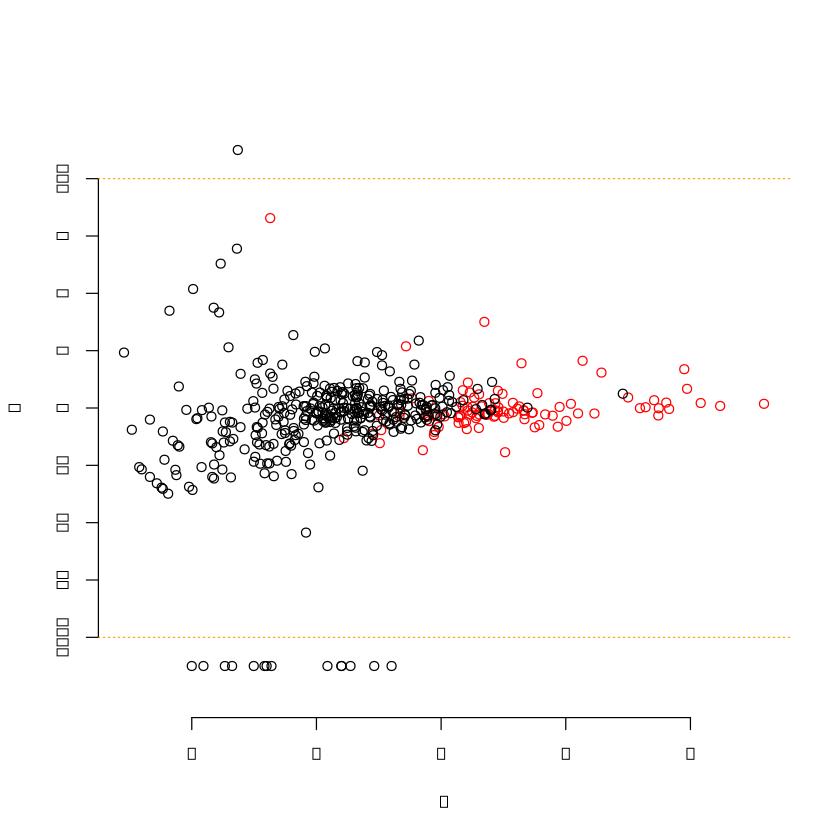

In [27]:
#We need to figure out how the MA plot is determined
cat(paste("Creating baySeq MA plot" ,"\n"))
plotMA.CD(CD, samplesA = "1", samplesB = "2", normaliseData=T, col = c(rep("red", 100), rep("black", 900)))

Creating baySeq Posterior Probability Plot


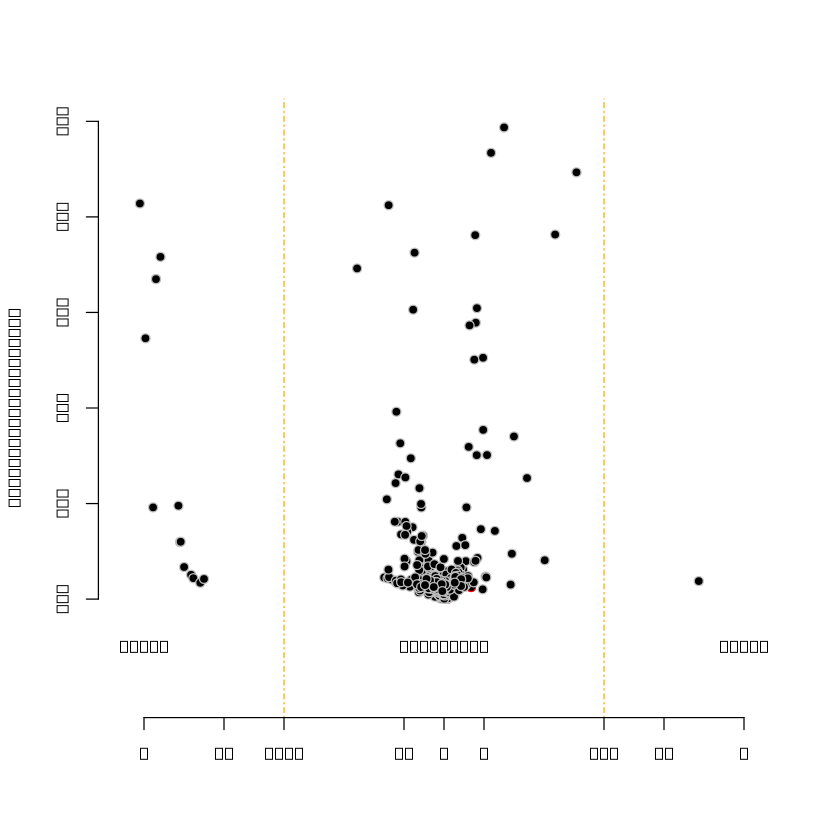

In [28]:
cat("Creating baySeq Posterior Probability Plot\n")
par(cex.axis=0.75, cex.lab=1)
plotPosteriors(CDPost.NBML, group = "DE", pch=21, bg="black", col=c(rep("red", nrow(bayseq.DE)), rep("gray", (nrow(bayseq)-nrow(bayseq.DE)))))

In [29]:
cat("Writing baySeq Results Table\n")
tmp_bayseq <- bayseq
tmp_bayseq$b_significant <- ifelse(tmp_bayseq$FDR <= pvalue, 'TRUE', 'FALSE')
outfile <- paste(input_filename,now,"baySeq.csv")
bayseq.out.data <- (cbind(tmp_bayseq[,1], substring(tmp_bayseq[,1], 4, 9), tmp_bayseq[,2:ncol(tmp_bayseq)]))
colnames(bayseq.out.data)[1:2] <- c("","UniProtID")
write.table(bayseq.out.data, file=outfile, sep=",", row.names=F)

Writing baySeq Results Table


In [30]:
#options(repr.vector.quote=FALSE)
bayseq.out.data

,,UniProtID,X03292017_UnX_IP2_,X03292017_UnX_IP3_,X03292017_UnX_IP4_,X03292017_WT_IP2_,X03292017_WT_IP3_,X03292017_WT_IP4_,Likelihood,ordering,FDR.DE,FWER.DE,b_significant
sp|Q04695|K1C17_HUMAN Keratin; type I cytoskeletal 17 OS=Homo sapiens GN=KRT17 PE=1 SV=2,sp|Q04695|K1C17_HUMAN Keratin; type I cytoskeletal 17 OS=Homo sapiens GN=KRT17 PE=1 SV=2,Q04695,53,73,85,10,8,8,0.9872,1>2,0.01275,0.01275,TRUE
sp|P15924|DESP_HUMAN Desmoplakin OS=Homo sapiens GN=DSP PE=1 SV=3,sp|P15924|DESP_HUMAN Desmoplakin OS=Homo sapiens GN=DSP PE=1 SV=3,P15924,35,22,23,4,6,6,0.9340,1>2,0.03935,0.07786,TRUE
sp|P09493|TPM1_HUMAN Tropomyosin alpha-1 chain OS=Homo sapiens GN=TPM1 PE=1 SV=2,sp|P09493|TPM1_HUMAN Tropomyosin alpha-1 chain OS=Homo sapiens GN=TPM1 PE=1 SV=2,P09493,39,22,8,0,1,0,0.8933,1>2,0.06181,0.17627,FALSE
sp|O75530|EED_HUMAN Polycomb protein EED OS=Homo sapiens GN=EED PE=1 SV=2,sp|O75530|EED_HUMAN Polycomb protein EED OS=Homo sapiens GN=EED PE=1 SV=2,O75530,0,0,0,7,6,12,0.8280,2>1,0.08934,0.31791,FALSE
sp|O14654|IRS4_HUMAN Insulin receptor substrate 4 OS=Homo sapiens GN=IRS4 PE=1 SV=1,sp|O14654|IRS4_HUMAN Insulin receptor substrate 4 OS=Homo sapiens GN=IRS4 PE=1 SV=1,O14654,2,3,0,12,13,7,0.8244,2>1,0.10659,0.43767,FALSE
sp|P07951|TPM2_HUMAN Tropomyosin beta chain OS=Homo sapiens GN=TPM2 PE=1 SV=1,sp|P07951|TPM2_HUMAN Tropomyosin beta chain OS=Homo sapiens GN=TPM2 PE=1 SV=1,P07951,17,11,5,0,1,0,0.7631,1>2,0.12831,0.57090,FALSE
sp|P05783|K1C18_HUMAN Keratin; type I cytoskeletal 18 OS=Homo sapiens GN=KRT18 PE=1 SV=2,sp|P05783|K1C18_HUMAN Keratin; type I cytoskeletal 18 OS=Homo sapiens GN=KRT18 PE=1 SV=2,P05783,56,68,70,22,28,18,0.7618,1>2,0.14401,0.67312,FALSE
sp|P34931|HS71L_HUMAN Heat shock 70 kDa protein 1-like OS=Homo sapiens GN=HSPA1L PE=1 SV=2,sp|P34931|HS71L_HUMAN Heat shock 70 kDa protein 1-like OS=Homo sapiens GN=HSPA1L PE=1 SV=2,P34931,7,9,7,24,33,11,0.7251,2>1,0.16037,0.76298,FALSE
sp|P31946|1433B_HUMAN 14-3-3 protein beta/alpha OS=Homo sapiens GN=YWHAB PE=1 SV=3,sp|P31946|1433B_HUMAN 14-3-3 protein beta/alpha OS=Homo sapiens GN=YWHAB PE=1 SV=3,P31946,0,0,0,6,4,3,0.7163,2>1,0.17408,0.83022,FALSE
sp|Q15022|SUZ12_HUMAN Polycomb protein SUZ12 OS=Homo sapiens GN=SUZ12 PE=1 SV=3,sp|Q15022|SUZ12_HUMAN Polycomb protein SUZ12 OS=Homo sapiens GN=SUZ12 PE=1 SV=3,Q15022,0,0,2,21,7,15,0.6921,2>1,0.18746,0.88249,FALSE


In [58]:
############################################
# Combine datasets
cat("Preparing Final Combined Output Files\n")

# extract UniProtIDs
protIDs.edgeR <- substring(rownames(tmp_edger),4,9)

# How to treat ties in ranking
rankties <- "min"

# extract edgeR pseudocounts and produce edgeR merged data matrix
code1 <- (g1+g2+3)
code2 <- (g1+g2+g1+g2+2)
raw.counts <- tmp_edger[1:(g1+g2)]
raw.counts.names <- paste("Raw_Counts", colnames(raw.counts), sep="_")
edgeR.pseudo.counts <- round(datafile.dgelist$pseudo.counts, digits=3)
edgeR.pseudo.counts.names <- paste("edgeR_Norm_Counts", colnames(edgeR.pseudo.counts), sep="_")
edgeR.stat.data <- tmp_edger[-(1:(g1+g2))]
edgeR.stat.data.names <- paste("edgeR_Analysis", colnames(edgeR.stat.data), sep="_")
mrg.edgeR <- cbind(Description=rownames(tmp_edger),raw.counts, UniProtID=protIDs.edgeR, edgeR.pseudo.counts, edgeR.stat.data)
row.names(mrg.edgeR) <- NULL
mrg.edgeR.names <- c("Description", raw.counts.names, "UniProtID_edgeR", edgeR.pseudo.counts.names, edgeR.stat.data.names)
colnames(mrg.edgeR) <- mrg.edgeR.names

# extract DESeq pseudocounts and produce DESeq merged data matrix
code3 <- (g1+g2+2)
DESeq.pseudo.counts <- round(t(t(counts(cds))/sizeFactors(cds)), digits=3)
DESeq.pseudo.counts.names <- paste("DESeq_Norm_Counts", colnames(DESeq.pseudo.counts), sep="_")
protIDs.DESeq <- substring(tmp_deseq[,1],4,9)
mrg.DESeq <- cbind(Description=tmp_deseq[,1], UniProtID=protIDs.DESeq, DESeq.pseudo.counts, tmp_deseq[,-1])
DESeq.stat.data.names <- paste("DESeq_Analysis", colnames(mrg.DESeq)[-(1:code3)], sep="_")
colnames(mrg.DESeq) <- c("Description", "UniProtID_DESeq", DESeq.pseudo.counts.names, DESeq.stat.data.names)

# produce baySeq merged data matrix - Replace any FDR=0 with 1E-8 for downstream analysis
code4 <- (g1+g2+1)
protIDs.baySeq <- substring(rownames(tmp_bayseq),4,9)
mrg.baySeq <- cbind(Description = rownames(tmp_bayseq),UniProtID=protIDs.baySeq, tmp_bayseq[,-(1:code4)])
baySeq.stat.data.names <- paste("baySeq_Analysis", colnames(mrg.baySeq)[-c(1,2)], sep="_")
colnames(mrg.baySeq) <- c("Description","UniProtID_baySeq", baySeq.stat.data.names)
mrg.baySeq$baySeq_Analysis_FDR.DE[mrg.baySeq$baySeq_Analysis_FDR.DE == 0] <- 1.00E-8

# Merge edgeR, DESeq and baySeq data
combined_table1 <- merge(mrg.edgeR, mrg.DESeq, by.x="Description", by.y="Description")
combined_table2 <- merge(combined_table1, mrg.baySeq, by.x="Description", by.y="Description")

cat("Calculating the MultiSpec q-Value\n")
Multi_Seq_Analysis_Med_qvalue <- rep(NA, nrow(combined_table2))
for (i in 1:nrow(combined_table2)){
Multi_Seq_Analysis_Med_qvalue[i] <- median(c(combined_table2$edgeR_Analysis_e_qvalue[i], combined_table2$DESeq_Analysis_d_qvalue[i], combined_table2$baySeq_Analysis_FDR.DE[i]))
}

combined_table2$Multi_Seq_Analysis_Med_qvalue <- Multi_Seq_Analysis_Med_qvalue
combined_table2$Multi_Spec_significant <- ifelse(combined_table2$Multi_Seq_Analysis_Med_qvalue <= pvalue, 'TRUE', 'FALSE')

cat("Calculate the MultiSpec Rank-Sum\n")
combined_table2$edgeR_Analysis_Rank <- rank(combined_table2$edgeR_Analysis_e_qvalue, ties.method=rankties)
combined_table2$DESeq_Analysis_Rank <- rank(combined_table2$DESeq_Analysis_d_qvalue, ties.method=rankties)
combined_table2$baySeq_Analysis_Rank <- rank(combined_table2$baySeq_Analysis_FDR.DE, ties.method=rankties)
Multi_Seq_Analysis_RankSum <- rep(NA, nrow(combined_table2))
for (i in 1:nrow(combined_table2)){
Multi_Seq_Analysis_RankSum[i] <- sum(c(combined_table2$edgeR_Analysis_Rank[i], combined_table2$DESeq_Analysis_Rank[i], combined_table2$baySeq_Analysis_Rank[i]))
}

combined_table2$Multi_Seq_Analysis_RankSum <- Multi_Seq_Analysis_RankSum
combined_table2$Multi_Seq_Analysis_Med_qvalue_Rank <- rank(combined_table2$Multi_Seq_Analysis_Med_qvalue, ties.method=rankties)

cat("Writing Final Results Table\n")
outfile <- paste(input_filename,now,"Final_Results.csv")
MultiSpecResults <- combined_table2[order(combined_table2$Multi_Seq_Analysis_Med_qvalue_Rank), ]
write.table(MultiSpecResults, file=outfile, sep=",", row.names=F)

Preparing Final Combined Output Files
Calculating the MultiSpec q-Value
Calculate the MultiSpec Rank-Sum
Writing Final Results Table


In [59]:
# Write out a simplified file
cat("Writing Combined Significance Table\n")
final_sig_data <- data.frame(as.character(combined_table2$Description), substring(combined_table2$Description, 4, 9), combined_table2$edgeR_Analysis_e_significant, combined_table2$DESeq_Analysis_d_significant, combined_table2$baySeq_Analysis_b_significant, as.numeric(combined_table2$edgeR_Analysis_e_qvalue), as.numeric(combined_table2$DESeq_Analysis_d_qvalue), as.numeric(combined_table2$baySeq_Analysis_FDR.DE), as.numeric(combined_table2$Multi_Seq_Analysis_RankSum), as.numeric(combined_table2$Multi_Seq_Analysis_Med_qvalue_Rank))
colnames(final_sig_data) <- c("Description","UniProtID", "e_significant","d_significant","b_significant", "e_qvalue", "d_qvalue", "b_FDR", "Multi_Spec_RankSum", "MultiSpec_Overall_Rank")
outfile <- paste(input_filename,now,"final_significant.csv")
write.table(final_sig_data[order(final_sig_data$MultiSpec_Overall_Rank), ], file=outfile, sep=",", row.names=F)

Writing Combined Significance Table


Creating Component Venn Diagram of Significant IDs


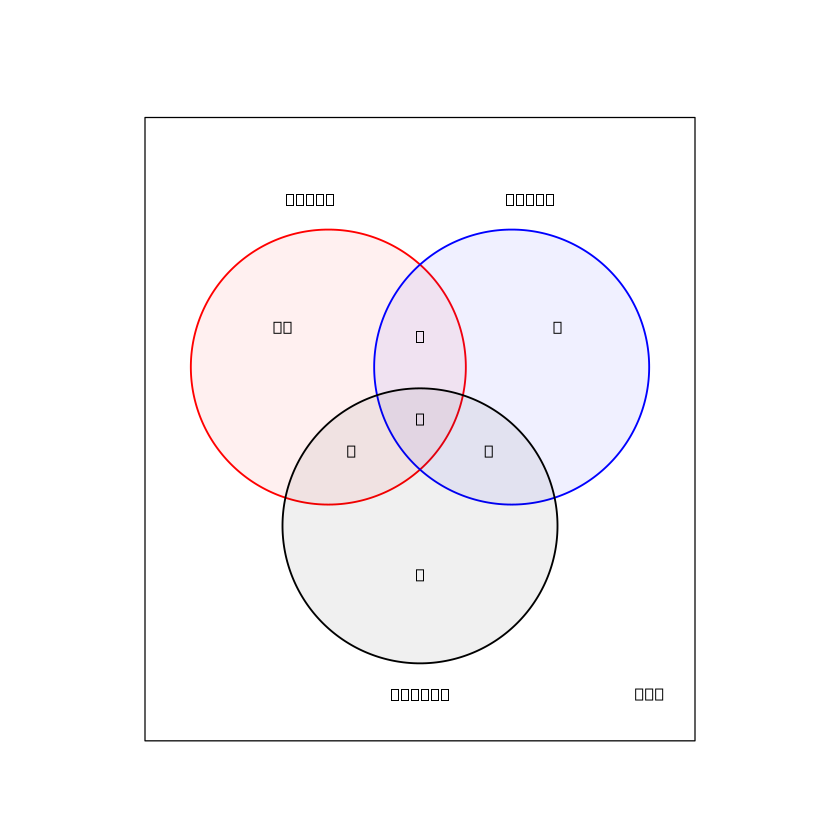

In [60]:
# Write out combined Venn Diagram for edgeR, DESeq and baySeq
cat("Creating Component Venn Diagram of Significant IDs\n")
Multi_Spec_qvalues <- cbind(combined_table2$edgeR_Analysis_e_significant, combined_table2$DESeq_Analysis_d_significant, combined_table2$baySeq_Analysis_b_significant)
venn_counts2 <-vennCounts(type.convert(Multi_Spec_qvalues))
#VENNPDFfile <- paste(filename, now, "component_Venn.pdf")
#pdf(file=VENNPDFfile )
vennDiagram(venn_counts2, include="both", names=c("edgeR", "DESeq", "baySeq"), counts.col=c("black"), circle.col=c("red", "blue", "black"), cex=2.2, lwd=1.5)
#garbage <- dev.off()

Creating MultiSpec Venn Diagram of Significant IDs


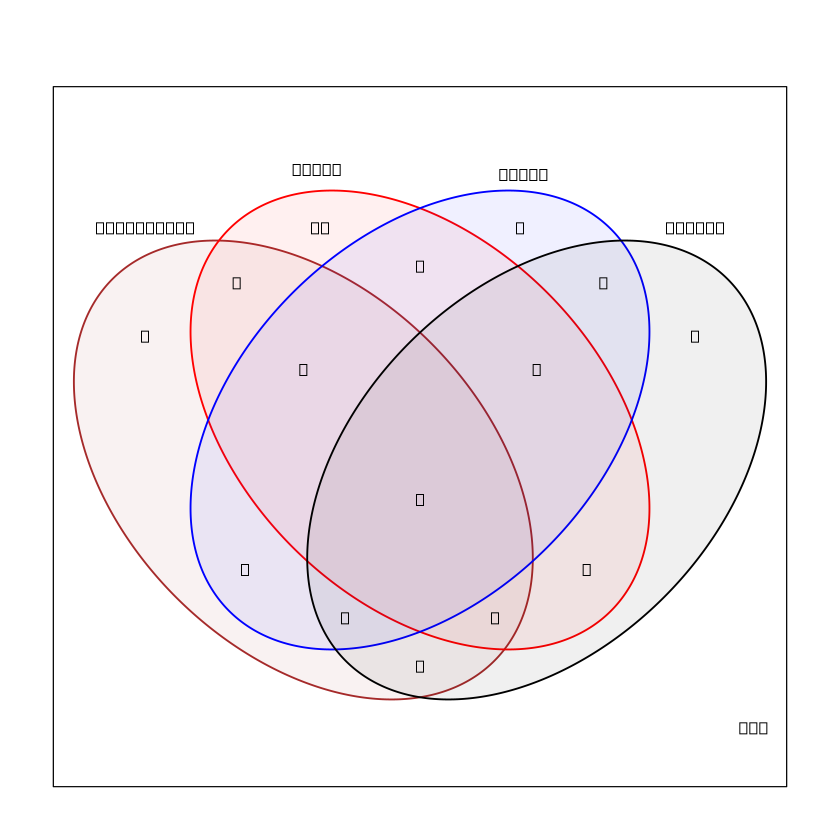

In [61]:
# Write out combined Venn Diagram for edgeR, DESeq and baySeq
cat("Creating MultiSpec Venn Diagram of Significant IDs\n")
Multi_Spec_qvalues <- cbind(combined_table2$Multi_Spec_significant, combined_table2$edgeR_Analysis_e_significant, combined_table2$DESeq_Analysis_d_significant, combined_table2$baySeq_Analysis_b_significant)
venn_counts3 <-vennCounts(type.convert(Multi_Spec_qvalues))
#VENNPDFfile <- paste(filename, now, "final_combined_Venn.pdf")
#pdf(file=VENNPDFfile )
par(mar=c(1,1,1,1))
vennDiagram(venn_counts3, include="both", names=c("Multi-Spec", "edgeR", "DESeq", "baySeq"), counts.col=c("black"), circle.col=c("brown", "red", "blue", "black"), cex=2.2, lwd=1.5)
#garbage <- dev.off()

Creating MultiSpec Origin Plot


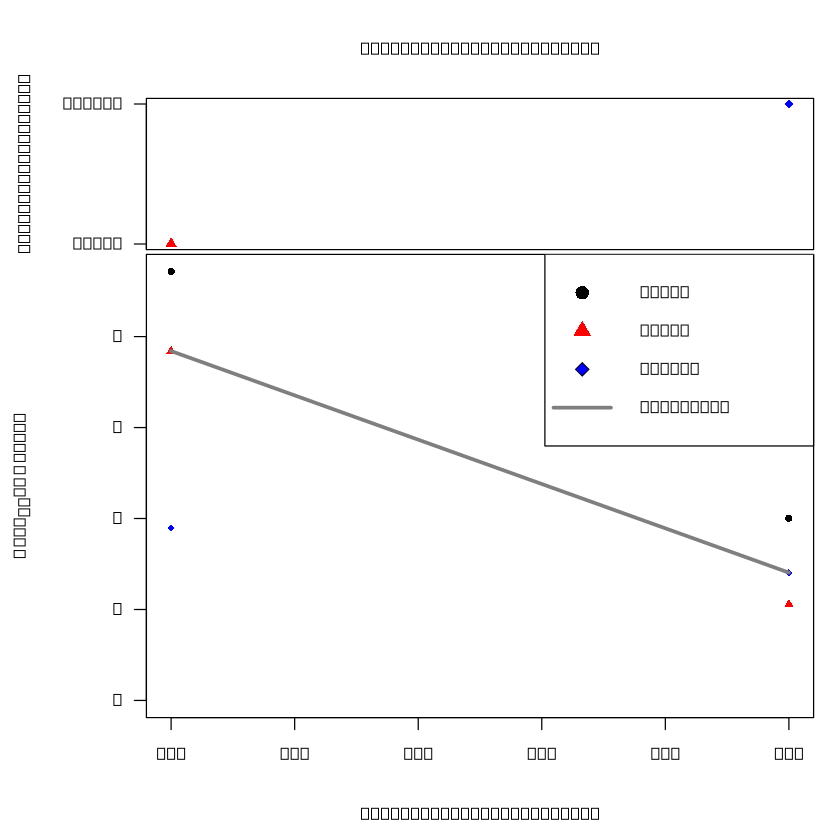

In [62]:
# Produce MultiSpec Rank/Origin Graphic
Plot.MultiSpecResults <- subset(MultiSpecResults, Multi_Seq_Analysis_Med_qvalue <= pvalue)
cat("Creating MultiSpec Origin Plot\n")
x <- vector(mode="numeric", length=nrow(Plot.MultiSpecResults))
for ( i in seq(1:nrow(Plot.MultiSpecResults))){
    if (Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue[i] == Plot.MultiSpecResults$edgeR_Analysis_e_qvalue[i]){
        x[i] <- 1
    }	else if (Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue[i] == Plot.MultiSpecResults$DESeq_Analysis_d_qvalue[i]){
        x[i] <- 2
    }	else if (Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue[i] == Plot.MultiSpecResults$baySeq_Analysis_FDR.DE[i]){
        x[i] <- 3
    }	else {
        x[i] <- 4
    }
}
y <- cbind(seq(1:nrow(Plot.MultiSpecResults)), x)
y1 <- subset(y, y[,2]==1)
y2 <- subset(y, y[,2]==2)
y3 <- subset(y, y[,2]==3)
plot.colors <- c("black", "red", "blue", "grey50")
plot.pchs <- c(16,17,18)
ymax <- max(-log(Plot.MultiSpecResults$edgeR_Analysis_e_qvalue,10),-log(Plot.MultiSpecResults$DESeq_Analysis_d_qvalue,10), -log(Plot.MultiSpecResults$baySeq_Analysis_FDR.DE,10))
#MultiSpecOriginPlot <- paste(filename, now, "MultiSpec_Origin_Plot.pdf")
#pdf(file=MultiSpecOriginPlot, height=11, width=8.5)
layout(mat=matrix(c(1,2),2,1, byrow=T), heights=c(3,7), respect=F)
par(mar=c(0,6,4,1) + 0.1)
plot(y[,1], y[,2], type="n", xlab="", ylab="", xaxt="n",  yaxt="n")
axis(2, c(1,2,3), labels=c("edgeR", "DESeq", "baySeq"), las=1, cex.axis=1.2)
title(ylab="Statistical Platform", cex.lab=1.5, line=4.6)
title(main="MultiSpec q-Value Origin", cex.main=2)
points(y1[,1], y1[,2], col=plot.colors[1], pch=plot.pchs[1])
points(y2[,1], y2[,2], col=plot.colors[2], pch=plot.pchs[2])
points(y3[,1], y3[,2], col=plot.colors[3], pch=plot.pchs[3])

par(mar=c(5,6,0,1) + 0.1)
plot(seq(1:nrow(Plot.MultiSpecResults)), seq(1:nrow(Plot.MultiSpecResults)), type="n", ylab="", xlab="", cex.axis=1.4, las=1, ylim=c(0,ymax))
title(xlab="MultiSpec Rank (q-value)", cex.lab=1.5, line=3.5)
title(ylab=expression(-Log[10]~q-Value), cex.lab=1.5, line=4.6)
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$edgeR_Analysis_e_qvalue,10), pch=plot.pchs[1], cex=0.8, col=plot.colors[1])
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$DESeq_Analysis_d_qvalue,10), pch=plot.pchs[2], cex=0.8, col=plot.colors[2])
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$baySeq_Analysis_FDR.DE,10), pch=plot.pchs[3], cex=0.8, col=plot.colors[3])
points(seq(1:nrow(Plot.MultiSpecResults)), -log(Plot.MultiSpecResults$Multi_Seq_Analysis_Med_qvalue,10), type="l", col=plot.colors[4], lwd=3)
legend("topright", c("edgeR", "DESeq", "baySeq", "MultiSpec"), pch=c(plot.pchs, NA), cex=1.5, lwd=c(NA,NA,NA,3), col=plot.colors)
#garbage <- dev.off()

Calculating Spearman Coorelations for q-Values/FDR
Creating Spearman q-Value Coorelation Plot matrix


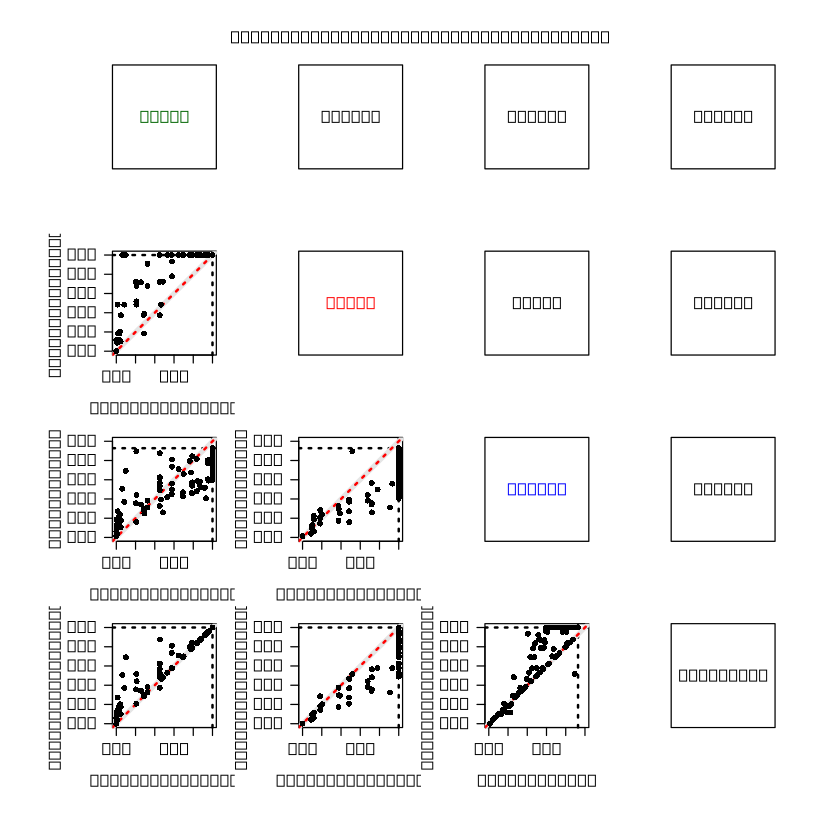

In [63]:
# Produce MultiSpec q-Value Spearman Coorelation Graphic
cat("Calculating Spearman Coorelations for q-Values/FDR\n")
eq <- MultiSpecResults$edgeR_Analysis_e_qvalue
dq <- MultiSpecResults$DESeq_Analysis_d_qvalue
bq <- MultiSpecResults$baySeq_Analysis_FDR.DE
mq <- MultiSpecResults$Multi_Seq_Analysis_Med_qvalue
cor.e.d <- cor(eq, dq, method="spearman")
cor.e.b <- cor(eq, bq, method="spearman")
cor.e.m <- cor(eq, mq, method="spearman")
cor.d.b <- cor(dq, bq, method="spearman")
cor.d.m <- cor(dq, mq, method="spearman")
cor.b.m <- cor(bq, mq, method="spearman")
cat("Creating Spearman q-Value Coorelation Plot matrix\n")

#SpearmanCoorlations <- paste(filename, now, "MultiSpec_q-Value_Coorelation_Matrix.pdf")
#pdf(SpearmanCoorlations, height=10, width=10)
cor.margs <- c(4,4,1,1) + 0.1
par(mfrow=c(4,4), mar=cor.margs, oma=c(3,3,3,3))
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "edgeR", col="darkgreen", cex=2)
plot(2, type="n", xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.e.d, 4), cex=4)
plot(2, type="n", xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.e.b, 4), cex=4)
plot(2, type="n", xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.e.m, 4), cex=4)
plot(eq, dq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - DESeq", xlab="q-Value - edgeR", las=1, type="n")
abline(h=max(dq), lty=3, lwd=2)
abline(v=max(eq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(eq, dq, pch=16)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "DESeq", col="red", cex=2)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.d.b, 4), cex=4)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.d.m, 4), cex=4)
plot(eq, bq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="FDR - baySeq", xlab="q-Value - edgeR", las=1, type="n")
abline(h=max(bq), lty=3, lwd=2)
abline(v=max(eq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(eq, bq, pch=16)
plot(dq, bq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="FDR - baySeq", xlab="q-Value - DESeq", las=1, type="n")
abline(h=max(bq), lty=3, lwd=2)
abline(v=max(dq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(dq, bq, pch=16)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "baySeq", col="blue", cex=2)
plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5,0.5, round(cor.b.m, 4), cex=4)

plot(eq, mq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - MultiSpec", xlab="q-Value - edgeR", las=1, type="n")
abline(h=max(mq), lty=3, lwd=2)
abline(v=max(eq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(eq, mq, pch=16)

plot(dq, mq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - MultiSpec", xlab="q-Value - DESeq", las=1, type="n")
abline(h=max(mq), lty=3, lwd=2)
abline(v=max(dq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(dq, mq, pch=16)

plot(bq, mq, ylim=c(0,1), xlim=c(0,1), cex.axis=1.3, cex.lab=1.4, ylab="q-Value - MultiSpec", xlab="FDR - baySeq", las=1, type="n")
abline(h=max(mq), lty=3, lwd=2)
abline(v=max(bq), lty=3, lwd=2)
abline(0,1, lwd=4, col="grey90")
abline(0,1, lty=3, lwd=2, col="red")
points(bq, mq, pch=16)

plot(2, xaxt="n", yaxt="n", xlab="", ylab="", ylim=c(0,1), xlim=c(0,1))
text(0.5, 0.5, "MultiSpec", cex=2)
mtext("Spearman q-Value/FDR Coorelation Plots", outer=T, cex=2)
#garbage <- dev.off()

# Produce MultiSpec Orphan Graphics
edgeR.orphan.cans <- subset(MultiSpecResults, edgeR_Analysis_e_qvalue <= pvalue & DESeq_Analysis_d_qvalue > pvalue & baySeq_Analysis_FDR.DE > pvalue)
edgeR.orphan <- data.frame(e=edgeR.orphan.cans$edgeR_Analysis_e_qvalue, d=edgeR.orphan.cans$DESeq_Analysis_d_qvalue, b=edgeR.orphan.cans$baySeq_Analysis_FDR.DE)
DESeq.orphan.cans <- subset(MultiSpecResults, edgeR_Analysis_e_qvalue > pvalue & DESeq_Analysis_d_qvalue <= pvalue & baySeq_Analysis_FDR.DE > pvalue)
DESeq.orphan <- data.frame(e=DESeq.orphan.cans$edgeR_Analysis_e_qvalue, d=DESeq.orphan.cans$DESeq_Analysis_d_qvalue, b=DESeq.orphan.cans$baySeq_Analysis_FDR.DE)
baySeq.orphan.cans <- subset(MultiSpecResults, edgeR_Analysis_e_qvalue > pvalue & DESeq_Analysis_d_qvalue > pvalue & baySeq_Analysis_FDR.DE <= pvalue)
baySeq.orphan <- data.frame(e=baySeq.orphan.cans$edgeR_Analysis_e_qvalue, d=baySeq.orphan.cans$DESeq_Analysis_d_qvalue, b=baySeq.orphan.cans$baySeq_Analysis_FDR.DE)

Creating MultiSpec Orphan Plots
  Plotting 12 edgeR Orphan Candidates 
  No DESeq Orphan Candidnates were Identified
  No baySeq Orphan Candidnates were Identified


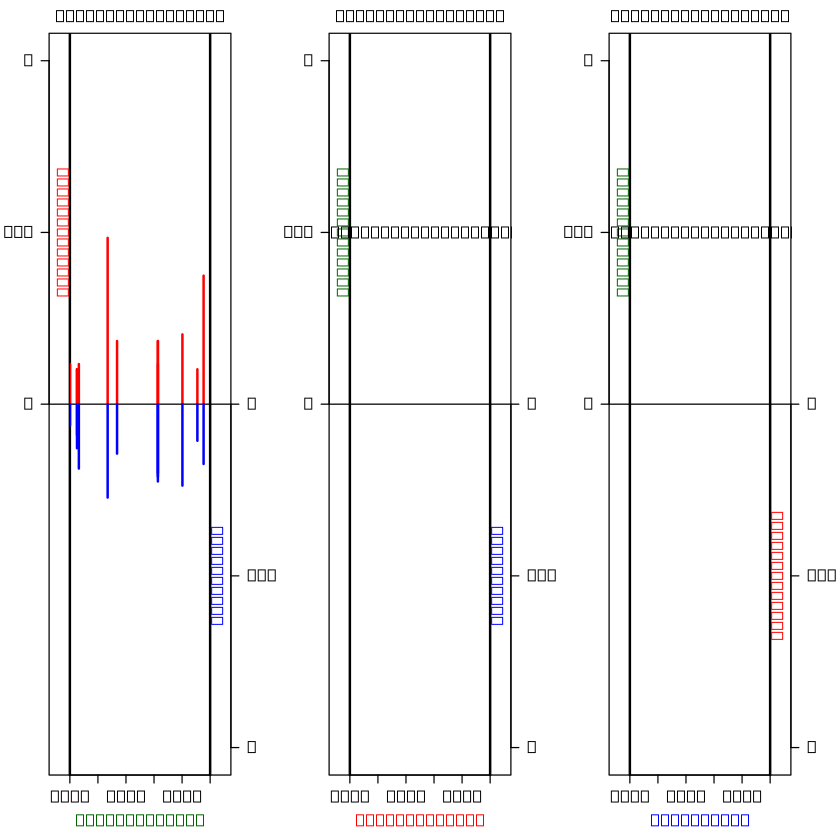

In [64]:
cat("Creating MultiSpec Orphan Plots\n")
orphan.plot.range <- c(0,pvalue)
orphan.x.lims <- c(-0.1*orphan.plot.range[2],1.1*orphan.plot.range[2])
par(mfrow=c(1,3))
plot.margins <- c(4,3,2,3)
if (nrow(edgeR.orphan) >=1){
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="edgeR Orphan Plot", cex.main=1.5)
	title(xlab="edgeR q-Value", cex.lab=1.5, line=2.5, col.lab="darkgreen")
    for (i in seq(1:nrow(edgeR.orphan))){
        y1.1 <- edgeR.orphan$d[i]
        y1.2 <- -edgeR.orphan$b[i]
        y2 <- 0
        x1 <- edgeR.orphan$e[i]
        x2 <- edgeR.orphan$e[i]
        clip(orphan.plot.range[1], orphan.plot.range[2], -1, 1)
        lines(y=c(y1.1, y2), x=c(x1, x2), lwd=2, col="red")
        lines(y=c(y1.2, y2), x=c(x1, x2), lwd=2, col="blue")
    }
    cat(paste("  Plotting", nrow(edgeR.orphan), "edgeR Orphan Candidates", sep=" "),"\n")
    
} else {
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="edgeR orphan Plot", cex.main=1.5)
	title(xlab="edgeR q-Value", cex.lab=1.5, line=2.5, col.lab="darkgreen")
	text(x=(orphan.plot.range[2]-orphan.plot.range[1])/2, y=0.5, "No Orphan Candidates", cex=1.5)
    cat("  No edgeR Orphan Candidnates were Identified\n")
}

if (nrow(DESeq.orphan) >=1){
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="DESeq Orphan Plot", cex.main=1.5)
	title(xlab="DESeq q-Value", cex.lab=1.5, line=2.5, col.lab="red")
    for (i in seq(1:nrow(DESeq.orphan))){
        y1.1 <- DESeq.orphan$e[i]
        y1.2 <- -DESeq.orphan$b[i]
        y2 <- 0
        x1 <- DESeq.orphan$d[i]
        x2 <- DESeq.orphan$d[i]
        clip(orphan.plot.range[1], orphan.plot.range[2], -1, 1)
        lines(y=c(y1.1, y2), x=c(x1, x2), lwd=2, col="darkgreen")
        lines(y=c(y1.2, y2), x=c(x1, x2), lwd=2, col="blue")
    }
    cat(paste("  Plotting", nrow(DESeq.orphan), "DESeq Orphan Candidates", sep=" "),"\n")
} else {
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "baySeq FDR", cex=1.5, srt=90, col="blue")
	title(main="DESeq Orphan Plot", cex.main=1.5)
	title(xlab="DESeq q-Value", cex.lab=1.5, line=2.5, col.lab="red")
	text(x=(orphan.plot.range[2]-orphan.plot.range[1])/2, y=0.5, "No Orphan Candidates", cex=1.5)
    cat("  No DESeq Orphan Candidnates were Identified\n")
}

if (nrow(baySeq.orphan) >=1){
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	title(main="baySeq Orphan Plot", cex.main=1.5)
	title(xlab="baySeq FDR", cex.lab=1.5, line=2.5, , col.lab="blue")
    
    for (i in seq(1:nrow(baySeq.orphan))){
        y1.1 <- baySeq.orphan$e[i]
        y1.2 <- -baySeq.orphan$d[i]
        y2 <- 0
        x1 <- baySeq.orphan$b[i]
        x2 <- baySeq.orphan$b[i]
        clip(orphan.plot.range[1], orphan.plot.range[2], -1, 1)
        lines(y=c(y1.1, y2), x=c(x1, x2), lwd=2, col="darkgreen")
        lines(y=c(y1.2, y2), x=c(x1, x2), lwd=2, col="red")
    }
    cat(paste("  Plotting", nrow(baySeq.orphan), "baySeq Orphan Candidates", sep=" "),"\n")
} else {
	par(mar=plot.margins + 0.1)
	plot(1,1, xlim=orphan.x.lims, ylim=c(-1,1), type="n", yaxt="n", xlab="", ylab="", cex.axis=1.2)
	abline(h=0)
	abline(v=orphan.plot.range, lwd=2)
	axis(4, at=c(0,-0.5, -1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	axis(2, at=c(0,0.5, 1), labels=c("0","0.5","1"), las=1, cex.axis=1.2)
	text(x=((orphan.x.lims[1]-orphan.plot.range[1])/2), y=0.5, "edgeR q-Value", cex=1.5, srt=90, col="darkgreen")
	text(x=orphan.plot.range[2]+((orphan.x.lims[2]-orphan.plot.range[2])/2), y=-0.5, "DESeq q-Value", cex=1.5, srt=90, col="red")
	title(main="baySeq Orphan Plot", cex.main=1.5)
	title(xlab="baySeq FDR", cex.lab=1.5, line=2.5, col.lab="blue")
	text(x=(orphan.plot.range[2]-orphan.plot.range[1])/2, y=0.5, "No Orphan Candidates", cex=1.5)
	cat("  No baySeq Orphan Candidnates were Identified\n")
}

In [66]:
#options(repr.vector.quote=FALSE)
MultiSpecResults

,Description,Raw_Counts_X03292017_UnX_IP2_,Raw_Counts_X03292017_UnX_IP3_,Raw_Counts_X03292017_UnX_IP4_,Raw_Counts_X03292017_WT_IP2_,Raw_Counts_X03292017_WT_IP3_,Raw_Counts_X03292017_WT_IP4_,UniProtID_edgeR,edgeR_Norm_Counts_X03292017_UnX_IP2_,edgeR_Norm_Counts_X03292017_UnX_IP3_,⋯,baySeq_Analysis_FDR.DE,baySeq_Analysis_FWER.DE,baySeq_Analysis_b_significant,Multi_Seq_Analysis_Med_qvalue,Multi_Spec_significant,edgeR_Analysis_Rank,DESeq_Analysis_Rank,baySeq_Analysis_Rank,Multi_Seq_Analysis_RankSum,Multi_Seq_Analysis_Med_qvalue_Rank
260,sp|Q04695|K1C17_HUMAN Keratin; type I cytoskeletal 17 OS=Homo sapiens GN=KRT17 PE=1 SV=2,53,73,85,10,8,8,Q04695,58.209,58.309,⋯,0.01275,0.01275,TRUE,0.0001443,TRUE,1,1,1,3,1
116,sp|P15924|DESP_HUMAN Desmoplakin OS=Homo sapiens GN=DSP PE=1 SV=3,35,22,23,4,6,6,P15924,38.336,17.450,⋯,0.03935,0.07786,TRUE,0.0393528,TRUE,6,2,2,10,2
81,sp|P09493|TPM1_HUMAN Tropomyosin alpha-1 chain OS=Homo sapiens GN=TPM1 PE=1 SV=2,39,22,8,0,1,0,P09493,42.632,17.493,⋯,0.06181,0.17627,FALSE,0.0618063,FALSE,2,6,3,11,3
41,sp|O75530|EED_HUMAN Polycomb protein EED OS=Homo sapiens GN=EED PE=1 SV=2,0,0,0,7,6,12,O75530,0.000,0.000,⋯,0.08934,0.31791,FALSE,0.0893431,FALSE,3,3,4,10,4
11,sp|O14654|IRS4_HUMAN Insulin receptor substrate 4 OS=Homo sapiens GN=IRS4 PE=1 SV=1,2,3,0,12,13,7,O14654,2.184,2.448,⋯,0.10659,0.43767,FALSE,0.1015564,FALSE,13,3,5,21,5
73,sp|P07951|TPM2_HUMAN Tropomyosin beta chain OS=Homo sapiens GN=TPM2 PE=1 SV=1,17,11,5,0,1,0,P07951,18.547,8.717,⋯,0.12831,0.57090,FALSE,0.1015564,FALSE,3,3,6,12,5
132,sp|P21333|FLNA_HUMAN Filamin-A OS=Homo sapiens GN=FLNA PE=1 SV=4,129,121,140,35,39,49,P21333,141.560,96.673,⋯,0.22508,0.96790,FALSE,0.1167547,FALSE,9,6,13,28,7
315,sp|Q15022|SUZ12_HUMAN Polycomb protein SUZ12 OS=Homo sapiens GN=SUZ12 PE=1 SV=3,0,0,2,21,7,15,Q15022,0.014,0.000,⋯,0.18746,0.88249,FALSE,0.1167547,FALSE,5,6,10,21,7
60,sp|P05783|K1C18_HUMAN Keratin; type I cytoskeletal 18 OS=Homo sapiens GN=KRT18 PE=1 SV=2,56,68,70,22,28,18,P05783,61.476,54.315,⋯,0.14401,0.67312,FALSE,0.1440136,FALSE,8,9,7,24,9
152,sp|P31946|1433B_HUMAN 14-3-3 protein beta/alpha OS=Homo sapiens GN=YWHAB PE=1 SV=3,0,0,0,6,4,3,P31946,0.000,0.000,⋯,0.17408,0.83022,FALSE,0.1740766,FALSE,14,14,9,37,10


In [67]:
#options(repr.vector.quote=FALSE)
final_sig_data[order(final_sig_data$MultiSpec_Overall_Rank), ]

,Description,UniProtID,e_significant,d_significant,b_significant,e_qvalue,d_qvalue,b_FDR,Multi_Spec_RankSum,MultiSpec_Overall_Rank
260,sp|Q04695|K1C17_HUMAN Keratin; type I cytoskeletal 17 OS=Homo sapiens GN=KRT17 PE=1 SV=2,Q04695,TRUE,TRUE,TRUE,1.928e-05,0.0001443,0.01275,3,1
116,sp|P15924|DESP_HUMAN Desmoplakin OS=Homo sapiens GN=DSP PE=1 SV=3,P15924,TRUE,FALSE,TRUE,9.926e-03,0.0881749,0.03935,10,2
81,sp|P09493|TPM1_HUMAN Tropomyosin alpha-1 chain OS=Homo sapiens GN=TPM1 PE=1 SV=2,P09493,TRUE,FALSE,FALSE,6.205e-05,0.1167547,0.06181,11,3
41,sp|O75530|EED_HUMAN Polycomb protein EED OS=Homo sapiens GN=EED PE=1 SV=2,O75530,TRUE,FALSE,FALSE,2.545e-03,0.1015564,0.08934,10,4
11,sp|O14654|IRS4_HUMAN Insulin receptor substrate 4 OS=Homo sapiens GN=IRS4 PE=1 SV=1,O14654,TRUE,FALSE,FALSE,4.545e-02,0.1015564,0.10659,21,5
73,sp|P07951|TPM2_HUMAN Tropomyosin beta chain OS=Homo sapiens GN=TPM2 PE=1 SV=1,P07951,TRUE,FALSE,FALSE,2.545e-03,0.1015564,0.12831,12,5
132,sp|P21333|FLNA_HUMAN Filamin-A OS=Homo sapiens GN=FLNA PE=1 SV=4,P21333,TRUE,FALSE,FALSE,3.138e-02,0.1167547,0.22508,28,7
315,sp|Q15022|SUZ12_HUMAN Polycomb protein SUZ12 OS=Homo sapiens GN=SUZ12 PE=1 SV=3,Q15022,TRUE,FALSE,FALSE,3.205e-03,0.1167547,0.18746,21,7
60,sp|P05783|K1C18_HUMAN Keratin; type I cytoskeletal 18 OS=Homo sapiens GN=KRT18 PE=1 SV=2,P05783,TRUE,FALSE,FALSE,1.682e-02,0.1837860,0.14401,24,9
152,sp|P31946|1433B_HUMAN 14-3-3 protein beta/alpha OS=Homo sapiens GN=YWHAB PE=1 SV=3,P31946,TRUE,FALSE,FALSE,4.767e-02,0.3741584,0.17408,37,10
